In [3]:
#loading required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from scipy.io import loadmat

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

#Loading Data

In [4]:
# Upload data on Drive copy it's path and paste below after mounting the Drive
#loading cerebral dataset
x=loadmat('sample_data/Dataset_41_13031.mat')
#x=loadmat('Dataset_41_13031.mat')
BATCH_SIZE = 32
IMG_SIZE = (41, 41)#dimension of input image
print(x['Input'].shape)
x_train=x['Input']
a = np.squeeze(x_train)
n_x = np.swapaxes(a,2,0)
a = np.arange(n_x.shape[0])
np.random.shuffle(a)
n_y=np.squeeze(x['Target'])

x_train = []
y_train = []
for i in a:
    x_train.append(n_x[i])
    y_train.append(n_y[i])

images = np.array(x_train).reshape([-1, 41,41,1])
x_train = np.concatenate((images,images,images), axis = -1)
print(x_train.shape)
#splitting data into train, validation and test sets
x_train, x_val,x_test = np.array(x_train[:9000]), np.array(x_train[9000:10500]), np.array(x_train[10500:])
y_train, y_val,y_test = np.array(y_train[:9000]), np.array(y_train[9000:10500]), np.array(y_train[10500:])


print(x_train.shape)
print(y_train.shape)

(41, 41, 1, 13031)
(13031, 41, 41, 3)
(9000, 41, 41, 3)
(9000,)


##Visualizing Data


Plotting some random images


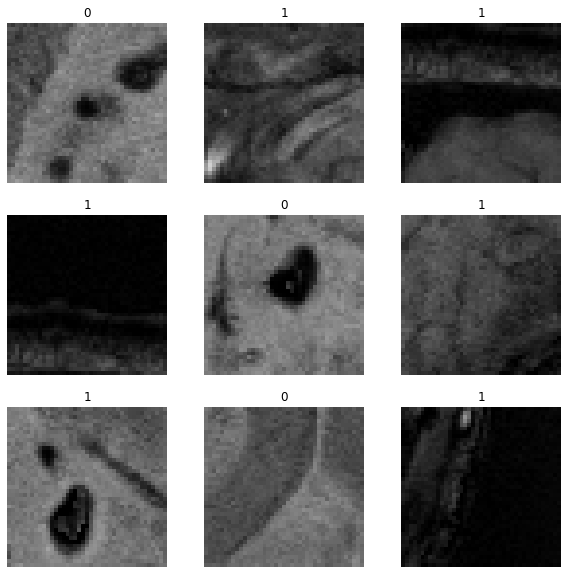

In [5]:
#visualizing some sample images from training set
print("Plotting some random images")

import matplotlib.pyplot as plt
n = np.random.randint(low = 0, high = 9000,size = [9])
a = np.squeeze(x_train)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(a[n[i]].astype("uint8"))
    plt.title(y_train[i])
    plt.axis("off")

#Data Augmentation

In [6]:
#performing data augmentation using random horizontal flip and random rotation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

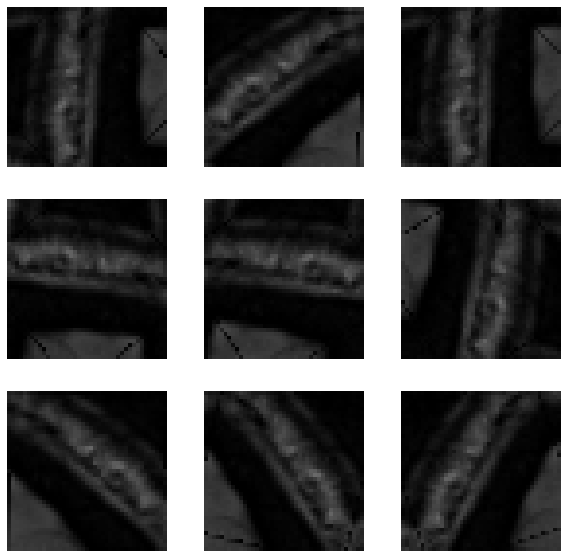

In [7]:
#visualizing images after performing different augmentations on train image

for image in x_train:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
    break

In [8]:
augmented_images = data_augmentation(x_train)

In [9]:
x_train.shape, augmented_images.numpy().shape

((9000, 41, 41, 3), (9000, 41, 41, 3))

In [10]:
new_lable = np.concatenate((y_train,y_train))

In [11]:
new_data = np.concatenate((x_train,augmented_images))

In [12]:
y_train.shape

(9000,)

In [13]:
#Preprocesses a tensor or Numpy array encoding a batch of images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
#Multiply inputs by scale and adds offset
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset= -1)

#Utility Fuctions


##Consfusion Matrix




In [15]:
#function to calculate confusion matrix
#model : trained deep learning model
#x : Input test data
#y : Ground truth labels of input test data
def plot_confusion_matrix(model,x,y): 
  y_test = [] 
  y_preds = []
  y_pred = model.predict(x)
  for i in range(len(y)):
    y_test.append(y[i])
    if y_pred[i]<=0:
      y_preds.append(0) 
    else :
      y_preds.append(1)
  cm = confusion_matrix(y_true = y_test, y_pred = y_preds) 
  print(cm)
  cm_normalize = normalize(cm, axis=1)

  plt.figure(figsize=(5,5)); 
  sns.heatmap(cm_normalize, annot=False, xticklabels=['0','1'], yticklabels=['0','1'], linewidths=.1);

  plt.savefig('confusion_matrix.png', bbox_inches='tight')

##Plotting Traing Graphs

In [16]:
def plot_curves(acc, val_acc, loss, val_loss):
  #plotting accuracy metric for different epochs
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')
  #plotting loss for different epochs
  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

#Model From Scratch 

In [17]:
initial_epochs = 100
#using early stopping so the model does not overfits on training
early_stopping  = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience = 3, verbose = 0, mode='auto', restore_best_weights=True
)

In [18]:
def CNN_model():
  #CNN Model consists of input layer, 5 convolutional blocks, 1 hidden layer and output layer
  inputs = Input(shape=(41,41,3))
  x = inputs#Input layer
  # Uncomment the lines for augmenting data
  # x = data_augmentation(inputs)
  # x = preprocess_input(x)
  #CONV1:first convolutional block
  x = Conv2D(75,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(7,7),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  x = Dropout(0.5)(x)
  #CONV2:second convolutional block
  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  #CONV3:third convolutional block
  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  #CONV4:fourth convolutional block
  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(150,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((2,2), strides = 2 , padding = 'same')(x)
  #CONV5:fifth convolutional block
  x = Conv2D(100,(7,7),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(50,(3,3),strides=1,padding='same',activation='swish')(x)
  x = Conv2D(25,(3,3),strides=1,padding='same',activation='swish')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D((1,1), strides = 2 , padding = 'same')(x)

  x = Flatten()(x)#flattening the output generated by previous convolutional block CONV5

  x = Dense(256, activation='swish')(x)#Fully connected layer, Changing from sigmoid to swish Step-7
  x = BatchNormalization()(x)# Sigmoid Step-8
  x = Dropout(0.2)(x)
  
  outputs = Dense(1)(x) #Output layer, Remove sigmoid
  print(outputs.shape)
  model = Model(inputs=inputs, outputs=outputs)
  model.summary() 
  return model

##Training Model

In [19]:
cnn = CNN_model()
base_learning_rate = 0.0001
#compiling CNN model with Adam as optimizer and Binary Crossentropy as final loss function
cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#training model using training and validation data
# history = cnn.fit(x_train,y_train,
#                     epochs=initial_epochs,
#                     callbacks = [early_stopping],
#                     validation_data=(x_val,y_val))
history = cnn.fit(new_data,new_lable,
                  shuffle = True,
                    epochs=initial_epochs,
                    callbacks = [early_stopping],
                    validation_data=(x_val,y_val))

(None, 1)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41, 41, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 41, 41, 75)        2100      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 150)       551400    
_________________________________________________________________
batch_normalization (BatchNo (None, 41, 41, 150)       600       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 150)       0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 150)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 

In [20]:
# Performance of cnn model in test data after training
loss0, accuracy0 = cnn.evaluate(x_test,y_test)

80/80 [==============================] - 1s 14ms/step - loss: 0.0093 - accuracy: 0.9972


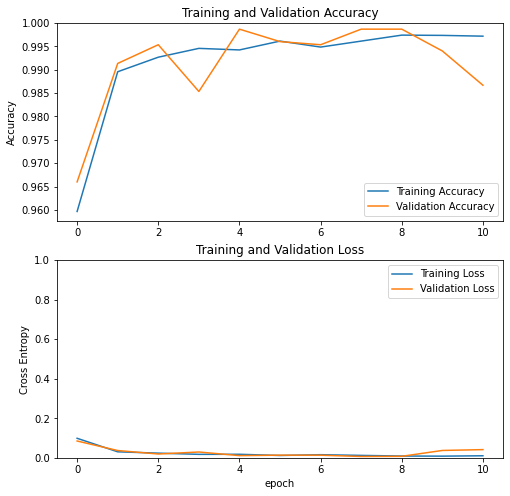

In [21]:
# Plotting learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
best_epoch = len(acc)
plot_curves(acc, val_acc, loss, val_loss)

#Transfer Learning
MobileNetV2


In [22]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
# Let's take a look to see how many layers are in the base model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 41, 41, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 43, 43, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 21, 21, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 21, 21, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [26]:
prediction_layer = tf.keras.layers.Dense(1)

In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
#compiling the model using adam optimizer and binary crossentropy as loss function
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)             

In [30]:
len(model.trainable_variables)

58

In [31]:

#calculating output labels of validation input data of transfer learning model without fine tuning or
# training the trainable layers
model.predict(x_val).shape
loss0, accuracy0 = model.evaluate(x_val,y_val)

47/47 [==============================] - 0s 6ms/step - loss: 1.1831 - accuracy: 0.3773


In [35]:
x_train.shape

(9000, 41, 41, 3)

In [36]:
#performance of transfer learning model without fine tuning or
# training the trainable layers on validation data
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.18
initial accuracy: 0.38


##Training Model


In [37]:
#training model using train and validation data with early stopping
# history = model.fit(x_train,y_train,
#                     epochs=initial_epochs,
#                     callbacks = [early_stopping],
#                     validation_data=(x_val,y_val))
history = model.fit(new_data,new_lable,
                    epochs=initial_epochs,
                    callbacks = [early_stopping],
                    validation_data=(x_val,y_val))

Epoch 1/100
563/563 [==============================] - 6s 11ms/step - loss: 0.0402 - accuracy: 0.9894 - val_loss: 0.0329 - val_accuracy: 0.9913
Epoch 2/100
563/563 [==============================] - 6s 10ms/step - loss: 0.0416 - accuracy: 0.9881 - val_loss: 0.0417 - val_accuracy: 0.9893
Epoch 3/100
563/563 [==============================] - 6s 11ms/step - loss: 0.0423 - accuracy: 0.9889 - val_loss: 0.0430 - val_accuracy: 0.9873
Epoch 4/100
563/563 [==============================] - 6s 11ms/step - loss: 0.0373 - accuracy: 0.9909 - val_loss: 0.0407 - val_accuracy: 0.9893


In [38]:
#Test performance of model on test data
loss0, accuracy0 = model.evaluate(x_test,y_test)

80/80 [==============================] - 1s 7ms/step - loss: 0.0398 - accuracy: 0.9893


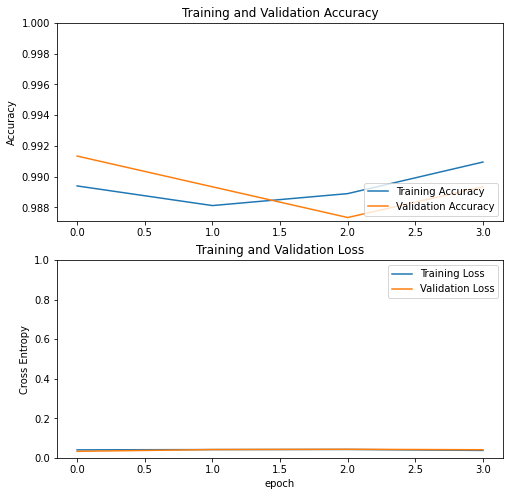

In [39]:
# Plotting Learning Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_curves(acc, val_acc, loss, val_loss)

#Comparing Models

CNN Model
[[1286    8]
 [   1 1236]]


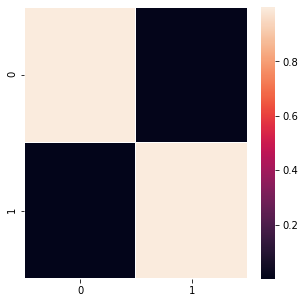

In [40]:
#Confusion matrix of test data classification by transfer learning model
print("CNN Model")
plot_confusion_matrix(cnn,x_test,y_test)

Transfer Learning - MobileNetV2
[[1271   23]
 [   4 1233]]


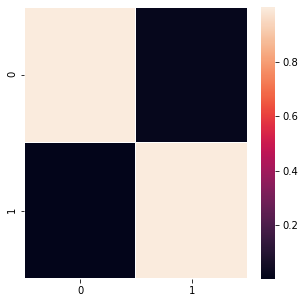

In [41]:
print("Transfer Learning - MobileNetV2")
plot_confusion_matrix(model,x_test,y_test)

##Best Model 


In [42]:
best_model = CNN_model()
base_learning_rate = 0.0001
#compiling CNN model with Adam as optimizer and Binary Crossentropy as final loss function
best_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = best_model.fit(np.concatenate((new_data,x_val)),np.concatenate((new_lable,y_val)),
                    epochs=initial_epochs,
                    callbacks = [early_stopping],
                    validation_data=(x_test,y_test))

(None, 1)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 41, 41, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 41, 41, 75)        2100      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 41, 41, 150)       551400    
_________________________________________________________________
batch_normalization_6 (Batch (None, 41, 41, 150)       600       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 150)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 21, 150)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 21, 

In [43]:
#Test performance of model on test data
loss0, accuracy0 = best_model.evaluate(x_test,y_test)

80/80 [==============================] - 1s 12ms/step - loss: 0.0077 - accuracy: 0.9988


Best Model
[[1291    3]
 [   1 1236]]


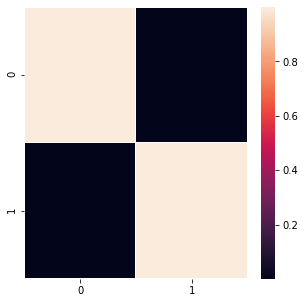

In [44]:
print("Best Model")
plot_confusion_matrix(best_model,x_test,y_test)

#Making Predictions

In [45]:
def predict(img):
  prediction = best_model.predict(img[np.newaxis,:,:,:])
  plt.imshow(img.astype("uint8"))
  plt.axis("off")
  if prediction < 0:
    return 0, "No clot found"
  else:
      return 1, "Clot found"

(0, 'No clot found')

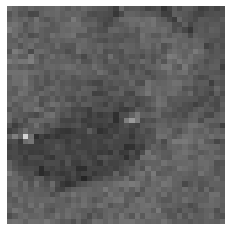

In [46]:
predict(x_test[1])